I share a spotify playlist with a friend and I wanted to see if there were any patterns in the sound signals that could be visualized. I realized that since I already had  access to my own spotify data I might as well transform into a "cutting-edge" data scientist and plot everything! 

# Data Access:

You are going to need an access token to get into your juicy data. In order to to that you need a [Bearer Token](https://stackoverflow.com/a/25843058). I followed Spotify's [tutorial](https://developer.spotify.com/documentation/web-api/quick-start/) and had my token in short amount of time.

# Data Retrieval:

At this point I assume you have a Token and which you can paste below.

In [48]:
TOKEN = 'BQA7nn9uD-gSRA8Mt5bLTIIGjP5qzypIFuYhNrXnww1dtNEaiPTRyKI2UqzbsRyfZDj1h2MTq5Qt9ec36RNSUsdTr7VwhW2tq6tHQ6Ah3eS0v0AcpTitkry8m7mmgW8dLqPDisJJhFRxKH-z2g0ZZVdFzsKVcN_9CWkRuVdCz-gOBrZV'

You can checkout all the [API endpoints](https://developer.spotify.com/documentation/web-api/reference-beta/) and see all Spotify has to offer. 

I wanted to analize songs so I chose the [Tracks](https://developer.spotify.com/documentation/web-api/reference/tracks/) endpoint. 

Note that tracks response and most endpoint responses for that matter are paginated. Some libraries can be composed of thousands of songs thefore a single request returning all the songs would impractical.

I just want to see how many songs are in my libary and fortunately we can access that field using the "total" key.

In [49]:
import json 
import requests

url = "https://api.spotify.com/v1/me/tracks"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
tracks = json.loads(r.text)
song_count = tracks["total"]
print("Total number of songs: {}".format(song_count))

Total number of songs: 874


For some reason I felt like my library had more than 870 songs. Either way lets get specific track objects

### Gathering Track Data

Spotify returns a maximum of [50 songs](https://developer.spotify.com/documentation/web-api/reference/library/get-users-saved-tracks/) if you specify the limit.

In [50]:

from math import ceil

all_songs = []

for i in range(int(ceil(song_count/50.0))):
    offset = 50*i
    url = "https://api.spotify.com/v1/me/tracks?limit=50&offset={}".format(offset)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = requests.get(url, headers=headers)
    tracks = json.loads(r.text)
    
    all_songs.extend(tracks["items"])
    
print("Number of gathered songs: {}".format(len(all_songs)))   

Number of gathered songs: 874


Awesome we have gathered all the tracks and can begin to dive into some data. 

Personally my goal was to observer wavelength patterns and get artsy with it. If this part sounds boring and you just want to plot other aspects of your spotify data keep scrolling.

Note that I am going to be changing urls because the goal of what I was doing was to compare my songs with my friends. My shared playlist is also 50 songs long. If I was working with my own library I would not do more than 50 songs.

The track object has an mp3 link that plays 30 seconds of each song. Im gonna download those mp3 files and convert them to wav files.

In [9]:
url = "https://api.spotify.com/v1/playlists/4zPScbIBFDKIKtCM3PvuJV"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
tracks = json.loads(r.text)

I iterate through the songs and get the url link for all songs. I also saved the name of the person that added the song, along with the song name, and the filename.

The mp3 data is retrived and saved onto and mp3 file. I use [Pydub](https://github.com/jiaaro/pydub) to convert the data to a wav file.

There will be url links which are empty I chose to take not of that by calling the filename "NoFile" and downloading and empty file. I did this to skip the files latter own but I guess I could have kept a list of files with no mp3 and check against those later  im too lazy though.

In [10]:
# Ignore the silly file path 
import urllib.request
import scipy.io.wavfile
import pydub
SONG_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/songs/'
DATA_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/'
meta_data = []

songs = tracks['tracks']['items']

for song in songs:
    added_by = song['added_by']['id']
    name = song['track']['name']
    name = name.replace(" ", "")
    web_file = song['track']['preview_url']
    if web_file == None:
        meta_data.append({"add_by": added_by, "name": name, "filename": "NoFile"})
        continue
    
    filename = added_by + "_" + name 
    meta_data.append({"add_by": added_by, "name": name, "filename": filename})
    #print("Song name: %s. Was added by: %s.\nFILENAME: %s. link=%s\n"%(name, added_by, filename, web_file))
    # Download file
    data = urllib.request.urlretrieve(web_file,SONG_FOLDER + filename + ".mp3")
    mp3 = pydub.AudioSegment.from_mp3(SONG_FOLDER + filename + ".mp3")
    mp3.export(SONG_FOLDER + filename +".wav", format="wav")
    #print("rate: %r\n"%(rate))


# I am adding the following cell to hide tiffs name 

In [13]:
import numpy as np
meta_data = []

for song in songs:
    added_by = song['added_by']['id']
    if added_by == "tknoodle1":
        added_by = "friend"
    name = song['track']['name']
    name = name.replace(" ", "")
    web_file = song['track']['preview_url']
    if web_file == None:
        meta_data.append({"add_by": added_by, "name": name, "filename": "NoFile"})
        continue
    
    filename = added_by + "_" + name 
    meta_data.append({"add_by": added_by, "name": name, "filename": filename})
    #print("Song name: %s. Was added by: %s.\nFILENAME: %s. link=%s\n"%(name, added_by, filename, web_file))
    # Download file
    data = urllib.request.urlretrieve(web_file,SONG_FOLDER + filename + ".mp3")
    mp3 = pydub.AudioSegment.from_mp3(SONG_FOLDER + filename + ".mp3")
    mp3.export(SONG_FOLDER + filename +".wav", format="wav")
    #print("rate: %r\n"%(rate))
    

In [14]:
meta_data = np.array(meta_data)
np.save(DATA_FOLDER + "playlist_meta_data.npy", meta_data)

# End of cell that deletes tiffs name

Now that we have the .wav files saved lets see how these waves look. 

We can get the [sampling rate](https://manual.audacityteam.org/man/sample_rates.html) and audio wave data.

In [30]:
rate, data  = scipy.io.wavfile.read(SONG_FOLDER+"file.wav")

We can see if the audio is mono or stereo. In this case we have a stereo recording as we grab both channels.

In [32]:
data.shape[1]

2

In [33]:
chan_1 = data[:, 0]
chan_2 = data[:, 1]

The values of the audio data represent the amplitude of the wave. We can decompose the audio wave into different frequency wave using a [Fourier transform](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/).

Text(0, 0.5, 'Amplitude')

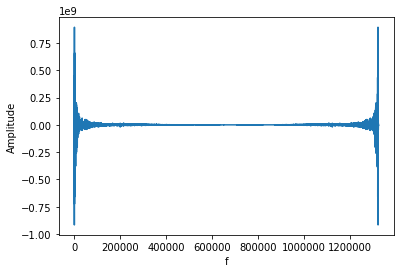

In [39]:
from numpy import fft as fft
import matplotlib.pyplot as plt
%matplotlib inline

fourier = fft.fft(chan_1)
plt.plot(fourier)
plt.xlabel('f')
plt.ylabel('Amplitude')


Im sure there are more things one can do with numpy or scipy and signals but I am grateful that [librosa](https://librosa.github.io/librosa/) exists. This library does all the heavy lifting of music and audio analyis. All I have to worry about is plotting.

Alright there are a few things happening here but you cant miss my skip NoFile "optimzation". First I load the file and get the data <strong>y</strong> and the sampling rate <strong>sr</strong> .

Then I seperate the [harmonic and percussive components](http://mir.ilsp.gr/harmonic_percussive_separation.html) of the audio.

I found the [Pitch Class](https://en.wikipedia.org/wiki/Pitch_class) as the coolest thing i could plot with little work. TL;DR A pitch is a specific note in a specific octave. However a pitch class is a specific note but any octave.

The last part is just seperating the chroma according to who added the song. Ultimatly the goal is to highlight differences or similarities between my friend's and my songs. 

In [44]:
import numpy as np

In [16]:
import librosa 

DATA_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/'

chromas = []
e_chromas = []
f_chromas = []
meta_data = np.load(DATA_FOLDER+"playlist_meta_data.npy")


for file in meta_data:    
    if file['filename'] == "NoFile":
        continue
    add_by = file['add_by']    
    filename = file['filename']+".wav"
    song_name = file['name']
    audio_path = SONG_FOLDER + filename
    # Load file
    y, sr = librosa.load(audio_path)
    # Split harmonics and percussives
    y_harmonic, _ = librosa.effects.hpss(y)
    C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    if add_by == 'friend':
        f_chromas.append({"chroma": C, "sr": sr })
    elif add_by == 'earleag':
        e_chromas.append({"chroma": C, "sr": sr})
    chromas.append({"add_by": add_by, "chroma": C, "sr": sr, "name": song_name}) 

We can graph the chroma using the display module from librosa.

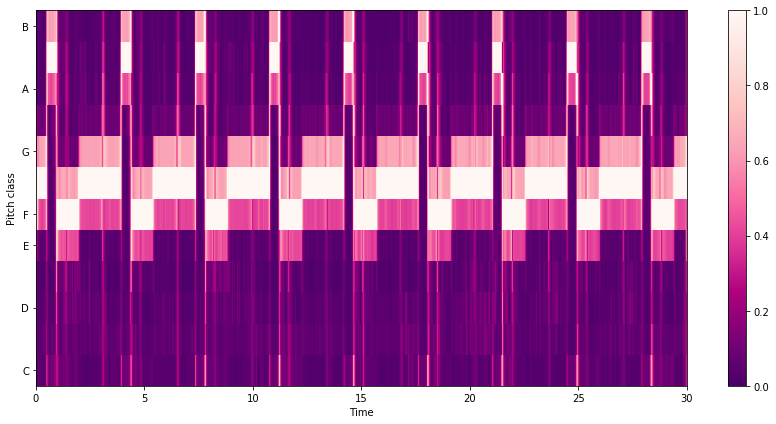

In [39]:
plt.figure(figsize=(12,6))
c = chromas[35]
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))
plt.colorbar()
plt.tight_layout()


I wanted to compare of a few of mine and my friend's chromas.  

Text(0, 0.5, '')

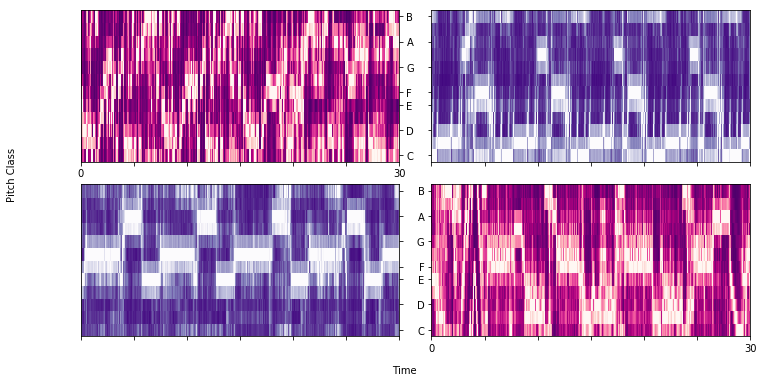

In [44]:

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(12, 6))
plt.subplots_adjust(hspace=0.15,wspace=0.1)
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Pitch Class', va='center', rotation='vertical')

ax1 = plt.subplot(2,2,1)
c = f_chromas[0]
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))
xticks = ax1.xaxis.get_major_ticks()
xticks[1].label1.set_visible(False)
xticks[2].label1.set_visible(False)
xticks[3].label1.set_visible(False)
xticks[4].label1.set_visible(False)
xticks[5].label1.set_visible(False)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.yaxis.tick_right()

ax2 = plt.subplot(2,2,2)    
c = e_chromas[1]
librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         x_axis='time', y_axis='chroma',
                               vmin=0, vmax=1,
                        cmap = plt.get_cmap('Purples_r'))


ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2.set_ylabel("")

ax3 = plt.subplot(2,2,3)
c = f_chromas[1]
librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         x_axis='time', y_axis='chroma',
                               vmin=0, vmax=1,
                        cmap = plt.get_cmap('Purples_r'))

ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.yaxis.tick_right()



ax4 = plt.subplot(2,2,4)    
c = e_chromas[2]
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))


xticks = ax4.xaxis.get_major_ticks()
xticks[1].label1.set_visible(False)
xticks[2].label1.set_visible(False)
xticks[3].label1.set_visible(False)
xticks[4].label1.set_visible(False)
xticks[5].label1.set_visible(False)
ax4.set_xlabel("")
ax4.set_ylabel("")

Here are all the tracks displayed side by side

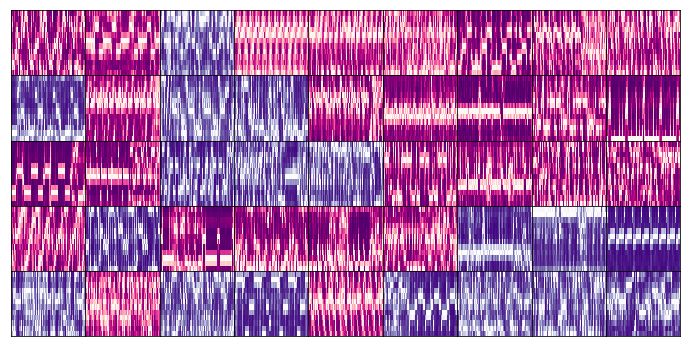

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa.display

from palettable.colorbrewer.sequential import GnBu_9_r
from palettable.matplotlib import Viridis_3
from palettable.cartocolors.sequential import Sunset_7_r

plt.figure(figsize=(12,6))
gs1 = gridspec.GridSpec(5, 9)
gs1.update(wspace=0.0, hspace=0.0)
gs_ix = 0

for chroma in chromas:
    plt.subplot(gs1[gs_ix])
    
    gs_ix = gs_ix + 1    
    #if chroma['name'] == 'Dreganomics' or chroma['name'] == 'Casio' or chroma['name'] == 'Fades' or chroma['name'] == 'Look@Ugo':
    #    librosa.display.specshow(chroma['chroma'], sr=chroma['sr'], 
    #                             vmin=0, vmax=1,  
    #                             cmap = plt.get_cmap('YlGnBu_r'))
    if chroma['add_by'] == 'friend':
        librosa.display.specshow(chroma['chroma'], 
                                sr=chroma['sr'], 
                               vmin=0, vmax=1,  
                              cmap = plt.get_cmap('RdPu_r'))
    elif chroma['add_by'] == 'earleag':        
        librosa.display.specshow(chroma['chroma'], 
                                 sr=chroma['sr'], 
                                 vmin=0, vmax=1,  
                                 cmap = plt.get_cmap('Purples_r'))


Alright thats it for sound analysis. Spotify aslo provides [song features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

We need ids to request the song features.

In [51]:
song_ids = []

for song in all_songs:
    _id = song['track']['id']
    song_ids.append(_id)
print("Number of ids gathered: {}".format(len(all_songs)))    

Number of ids gathered: 874


In [ ]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
song_features_by_id = {}

s = requests.Session()
retries = Retry(total=300, backoff_factor=1, 
                status_forcelist=[502,503,504,429])
s.mount('https://', HTTPAdapter(max_retries=retries))

for song_id in song_ids:
    url = "https://api.spotify.com/v1/audio-features/{}".format(song_id)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = s.get(url, headers=headers)
    
    parsed = json.loads(r.text)
    
    song_info = parsed

    
    try:
        a = song_info["type"]
    except:
        print(parsed)
        
    song_features_by_id[song_id] = song_info

song_features_by_id[song_ids[0]]

/home/lildreamz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'liveness of Songs')

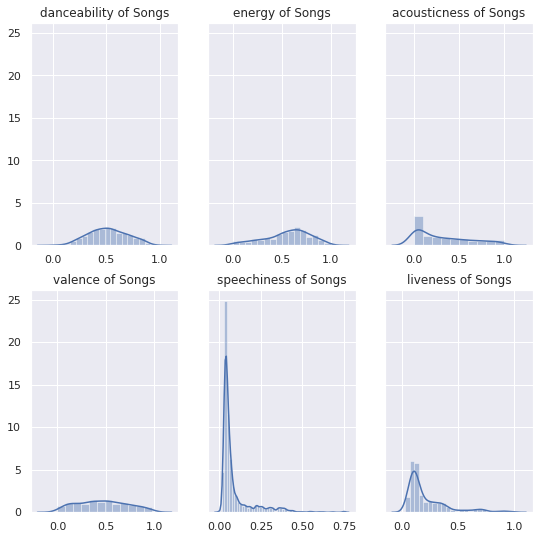

In [56]:
import seaborn as sns


danceability =  []
energy = []
acousticness = []
valence = []
speechiness = []
liveness = []    

for song_id in song_features_by_id:
    d = song_features_by_id[song_id]['danceability']
    e = song_features_by_id[song_id]['energy']
    a = song_features_by_id[song_id]['acousticness']
    v = song_features_by_id[song_id]['valence']
    s = song_features_by_id[song_id]['speechiness']
    l = song_features_by_id[song_id]['liveness']
    speechiness.append(s)
    valence.append(v)
    acousticness.append(a)    
    energy.append(e)
    danceability.append(d)
    liveness.append(l)

sns.set(color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(9,9), sharey=True)   


ax = sns.distplot(danceability, ax=axes[0,0])
ax.set_title("danceability of Songs")

ax = sns.distplot(energy, ax=axes[0,1])
ax.set_title("energy of Songs")

ax = sns.distplot(acousticness, ax=axes[0,2])
ax.set_title("acousticness of Songs")

ax = sns.distplot(valence, ax=axes[1,0])
ax.set_title("valence of Songs")

ax = sns.distplot(speechiness, ax=axes[1,1])
ax.set_title("speechiness of Songs")

ax = sns.distplot(liveness, ax=axes[1,2])
ax.set_title("liveness of Songs")

In [ ]:
import pandas as pd

song_features_df = pd.DataFrame(
    { 'Danceability': danceability,
      'Energy': energy,
      'Acousticness': acousticness,
      'Valence': valence,
      'Speechiness': speechiness,
      'liveness': liveness
    })

In [ ]:
sns.pairplot(song_features_df)